In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
file = pd.read_excel('https://raw.githubusercontent.com/mohitgabani1/Well-Testing/main/oil_well_buildup_solution.xlsx',sheet_name='Data')

In [3]:
file.head()

,Time(hrs),Shut-in Pressure
0,0.0000,4192.887177
1,0.0010,4196.716637
2,0.0021,4201.194377
3,0.0034,4207.221945
4,0.0048,4212.246464


In [4]:
df = file.copy()

In [5]:
df.columns = ['time','pressure']

In [6]:
df

,time,pressure
0,0.0000,4192.887177
1,0.0010,4196.716637
2,0.0021,4201.194377
3,0.0034,4207.221945
4,0.0048,4212.246464
...,...,...
80,98.9100,6043.560116
81,111.2800,6047.385168
82,125.1900,6051.069483
83,140.8400,6055.066063


# Given Data:

In [7]:
pi = 6200 # psia
q = 2000 # flowrate, stb/d
h = 125 # formation thickness, ft
phi = 0.15 # porosity
ct = 47.4*(10**(-6)) # total compressibility, psi^-1
bo = 1.2 # oil formation volume factor, bbl/stb
u = 0.3 # oil viscosity, cp
rw = 0.325 # wellbore radius, ft
tp = 168 # producig hours

In [8]:
pwf = df.loc[0,'pressure'] # bottom hole pressure at the starting of buildup test
pwf

4192.887177092483

In [9]:
df['pressure_diff'] = df['pressure']-pwf # Pwf - Pws

In [10]:
for i in range(len(df['pressure'])-1):
    df.loc[i+1,'delPws'] = df.loc[i+1,'pressure']-df.loc[i,'pressure'] # difference between two consecutive bottom hole shut in pressure
    df.loc[i+1,'horner_time'] = (tp+df.loc[i+1,'time'])/df.loc[i+1,'time'] # horner's time
    df.loc[i+1,'t_eff'] = tp/df.loc[i+1,'horner_time'] # effective time

In [11]:
for i in range(len(df['pressure'])-2):
    df.loc[i+2,"del_teff"] = df.loc[i+2,'t_eff']-df.loc[i+1,'t_eff'] # consecutive difference of effective time
    df.loc[i+2,"p'"] = df.loc[i+2,'t_eff']*df.loc[i+2,'delPws']/df.loc[i+2,'del_teff'] # pressure derivative

In [12]:
df.head()

,time,pressure,pressure_diff,delPws,horner_time,t_eff,del_teff,p'
0,0.0000,4192.887177,0.000000,NaN,NaN,NaN,NaN,NaN
1,0.0010,4196.716637,3.829460,3.829460,168001.000000,0.0010,NaN,NaN
2,0.0021,4201.194377,8.307200,4.477741,80001.000000,0.0021,0.0011,8.548465
3,0.0034,4207.221945,14.334768,6.027568,49412.764706,0.0034,0.0013,15.764605
4,0.0048,4212.246464,19.359287,5.024519,35001.000000,0.0048,0.0014,17.227271


In [13]:
df = df.loc[2:,:]

# Semi log plot:

In [27]:
fig = px.line(data_frame=df, x = 'horner_time',y='pressure', log_x=True, title='Semi-Log plot (Pws vs log(t))',hover_data=['time'])
fig.add_trace(trace=px.scatter(data_frame=df, x = 'horner_time',y='pressure').data[0])
fig.update_layout(xaxis_title="Horner's time", yaxis_title='Shut-in Pressure, psia')

In [15]:
# slope calculation: IARF region
t_lower = 2 # in between lower and upper time plot of Pwf vs log(time) is linear. so this region is used to calculate slope
t_upper = 60

In [16]:
# this is IARF region data:

df1 = df[(df['horner_time']>t_lower)&(df['horner_time']<t_upper)].reset_index(drop=True)

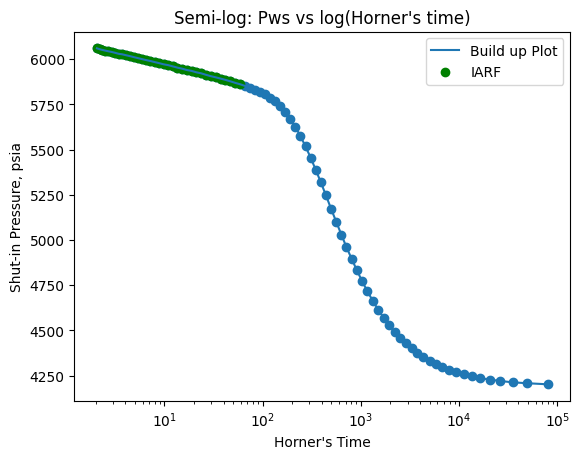

In [17]:
data=df.loc[1:,]
plt.plot(data['horner_time'],data['pressure'], label = "Build up Plot")
plt.scatter(data['horner_time'],data['pressure'])
plt.xscale('log')
plt.title("Semi-log: Pws vs log(Horner's time)")
plt.xlabel("Horner's Time")
plt.ylabel("Shut-in Pressure, psia")
plt.scatter(df1['horner_time'],df1['pressure'], color='green', label='IARF')
plt.legend()
plt.show()

In [18]:
fit = np.polyfit(np.log10(df1['horner_time']),df1['pressure'], deg=1)

### Permeability: 

In [19]:
slope = fit[0]
print(f"Slope of IARF region: {abs(slope)}")

Slope of IARF region: 133.46366043157107


In [20]:
k = 162.6*(q*bo*u/(abs(slope)*h))
print(f"permeability: {k} md")

permeability: 7.01746076026588 md


### skin: 

In [21]:
s = 1.151*((df1.loc[0,'pressure']-pwf)/abs(slope) - np.log10(df1.loc[0,'t_eff']) - np.log10(k/(phi*u*ct*rw**2)) +3.23)
print(f"skin: {s}")

skin: 8.956159367175822


# Log-Log plot:

In [28]:
fig = px.line(data_frame=df, x = 't_eff',y='pressure_diff', log_x=True, log_y=True, title='Diagnostic Plot')
fig = fig.add_trace(trace=px.scatter(data_frame=df, x = 't_eff',y='pressure_diff').data[0])
fig1 = fig.add_trace(trace=px.scatter(data_frame=df, x = 't_eff',y="p'").data[0])
fig1 = fig.add_trace(trace=px.line(data_frame=df, x = 't_eff',y="p'").data[0])
fig2 = fig.add_trace(trace=px.line(data_frame=df1, x = 't_eff',y="p'").data[0]).update_traces(line_color='red')
fig.update_layout(xaxis_title='Effective time, hours', yaxis_title='Pressure Derivative, psia')
fig.update_traces(marker={'symbol':'x'}, )

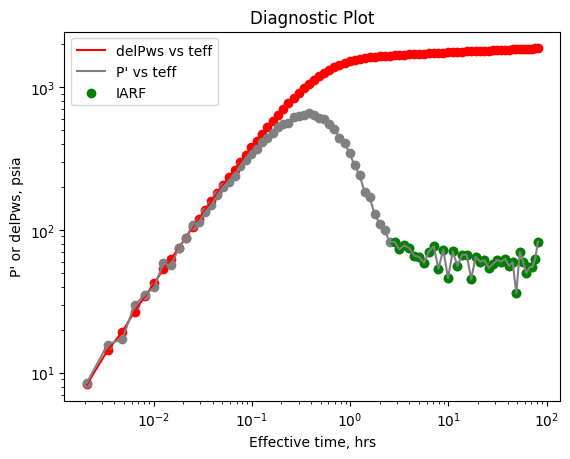

In [23]:
plt.plot(data['t_eff'],data['pressure_diff'], label = "delPws vs teff", color='red')
plt.scatter(data['t_eff'],data['pressure_diff'], color='red')
plt.plot(data['t_eff'],data["p'"], label = "P' vs teff", color='grey')
plt.scatter(data['t_eff'],data["p'"], color='grey')
plt.xscale('log')
plt.yscale('log')
plt.title("Diagnostic Plot")
plt.xlabel("Effective time, hrs")
plt.ylabel("P' or delPws, psia")
plt.scatter(df1['t_eff'],df1["p'"], color='green', label='IARF')
plt.legend()
plt.show()

In [24]:
# from graph
p_derivative = 60.1
k = 141.2*q*bo*u*0.5/(p_derivative*h)
print(f"permeability: {k} md")

permeability: 6.7663227953410985 md


In [25]:
s = 1.151*((df1.loc[0,'pressure']-pwf)/abs(slope) - np.log10(df1.loc[0,'t_eff']) - np.log10(k/(phi*u*ct*rw**2)) +3.23)
print(f"skin: {s}")

skin: 8.974376566898073
